In [41]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ift6758.utilities.game_utilities import filter_by_team_and_season, generate_shot_map_matrix, get_goals_per_game
from scipy.ndimage import gaussian_filter

sns.set()

In [42]:
plays_df = pd.read_csv("./data/extracted/shot_goal_20161012_20210707.csv")

In [43]:
season = 20202021
team = 'Tampa Bay Lightning'
bin_size = 1

team_df = filter_by_team_and_season(plays_df, team, season)

global_matrix = generate_shot_map_matrix(plays_df, bin_size=bin_size)
global_goals_per_game = get_goals_per_game(plays_df, season_filter=season)
team_matrix = generate_shot_map_matrix(team_df, bin_size=bin_size)
team_goals_per_game = get_goals_per_game(team_df, team_filter=team, season_filter=season)

print(f'Shots per game: {team_matrix.sum().sum()}')
print(f'Shots differential per game compared to NHL average: {team_matrix.sum().sum() - global_matrix.sum().sum()} ({(team_matrix.sum().sum() - global_matrix.sum().sum()) / global_matrix.sum().sum() * 100}%)')
print(f'Goals scored per game: {team_goals_per_game}')
print(f'Goals scored differential per game compared to NHL average: {team_goals_per_game - global_goals_per_game} ({(team_goals_per_game - global_goals_per_game) / global_goals_per_game * 100}%)')

difference_matrix = np.subtract(team_matrix.align(global_matrix, fill_value=0)[0], global_matrix)
# Sort by decreasing distance from center ice so center ice appears at the bottom of the graph
difference_matrix.sort_index(ascending=False, kind='mergesort', inplace=True)

Shots per game: 32.34567901234568
Shots differential per game compared to NHL average: 2.3667999170521448 (7.8948912983998625%)
Goals scored per game: 2.7160493827160495
Goals scored differential per game compared to NHL average: -0.25655335700997783 (-8.630596802639808%)


<AxesSubplot:xlabel='Distance from center of rink (ft)', ylabel='Distance from center ice to goal (ft)'>

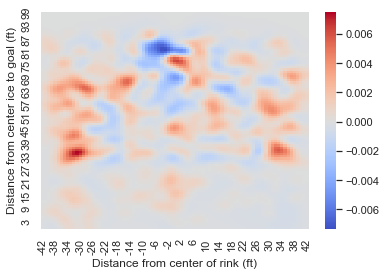

In [44]:
df3_smooth = gaussian_filter(difference_matrix, sigma=2, order=0)
difference_matrix_smooth = pd.DataFrame(data=df3_smooth, index=difference_matrix.index, columns=difference_matrix.columns)
sns.heatmap(difference_matrix_smooth, cmap ="coolwarm", center=0)